In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pylab as plt
import PIL.Image as Image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)

In [3]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [4]:
IMAGE_SHAPE = (224, 224,)
input_shape = IMAGE_SHAPE + (3,)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=input_shape)
])

In [5]:
img_path = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')

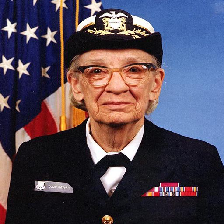

In [6]:
img = Image.open(img_path).resize(IMAGE_SHAPE)
img

In [7]:
img_np = np.array(img) / 255.0
img_np.shape

(224, 224, 3)

In [8]:
result = classifier.predict(img_np[np.newaxis,...])
result.shape

(1, 1001)

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [11]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [17]:
prob = np.exp(result[0])
prob = prob / np.sum(prob)
prob[predicted_class]

0.8923895

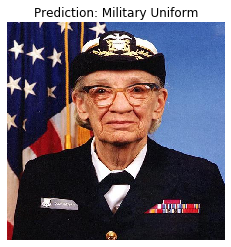

In [12]:
plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [18]:
data_root = tf.keras.utils.get_file('flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
       untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [19]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [21]:
for image_batch, label_batch in image_data:
    print('Image batch shape: ', image_batch.shape)
    print('Label batch shape: ', label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [22]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [23]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(["yellow lady's slipper", 'daisy', 'daisy', 'alp', 'daisy',
       'cardoon', 'daisy', 'vase', 'spider web', 'cardoon', 'sea urchin',
       'gown', 'plow', 'coral reef', 'bell pepper', 'daisy', 'daisy',
       'vase', 'vase', 'pot', 'daisy', 'bell pepper', 'cardoon',
       'rapeseed', 'goblet', 'bee', 'pinwheel', 'barn spider', 'ear',
       'bee', 'daisy', 'daisy'], dtype='<U30')

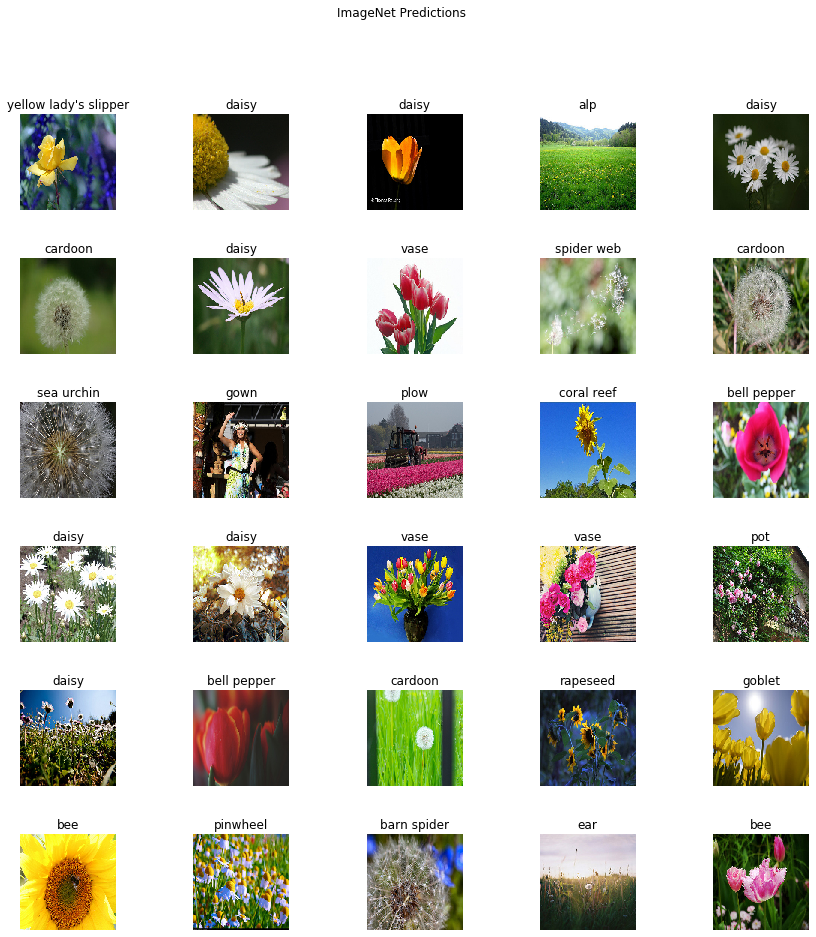

In [27]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle('ImageNet Predictions')

In [28]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [35]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=input_shape, name='feature_extractor')

In [37]:
feature_batch = feature_extractor_layer(image_batch)
feature_batch.shape

TensorShape([32, 1280])

In [38]:
feature_extractor_layer.trainable=False

In [39]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(units=image_data.num_classes, activation='softmax')
])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (KerasLaye (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics=['acc'])

In [43]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = list()
        self.batch_acc = list()

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()


In [44]:
steps_per_epoch = np.ceil(image_data.samples / image_data.batch_size)
batch_stats_callback = CollectBatchStats()
history = model.fit(image_data, epochs=2, steps_per_epoch=steps_per_epoch,
                   callbacks=[batch_stats_callback])

Epoch 1/2


W0607 16:16:26.296587 26424 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 19s 169ms/step - loss: 0.8243 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 17s 151ms/step - loss: 0.4958 - acc: 0.9375


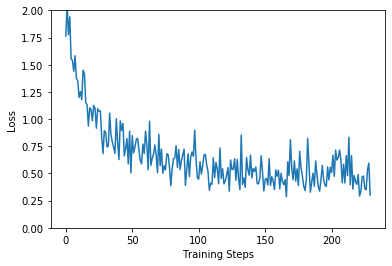

In [51]:
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

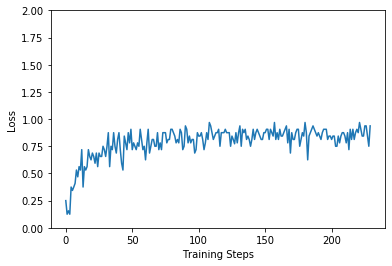

In [52]:
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_acc)

In [53]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [54]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [55]:
label_id = np.argmax(label_batch, axis=-1)

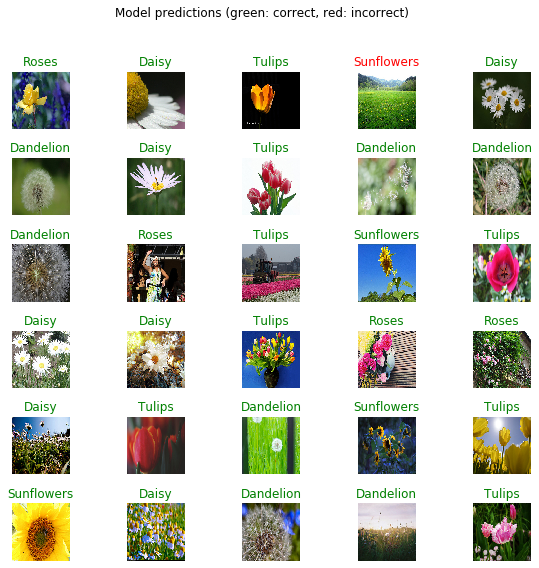

In [56]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")